In [179]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/cmac_env/share/proj/'
from dask_jobqueue import PBSCluster
from dask.distributed import Client, metrics, wait
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, progress
import pyart
import netCDF4
import xarray
import tempfile
import shutil
from netCDF4 import num2date
import json
#from time import strftime, sleep
import datetime
import glob
import subprocess
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [180]:
"""
pyart.retrieve.quasi_vertical_profile
=====================================

Retrieval of QVPs from a radar object

.. autosummary::
    :toctree: generated/

    quasi_vertical_profile

"""

import numpy as np

from pyart.core import antenna_to_cartesian



def quasi_vertical_profile(radar, fields = None, gatefilter = None):
    
    """
    Quasi Vertical Profile.
    
    Creates a QVP object ....
    
    
    Parameters
    ----------
    radar : Radar
        Radar object used.
    field : string
        Radar field to use for QVP calculation.
    
    Other Parameters
    ----------------
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the import qvp calculation
        
    Returns
    -------
    qvp : Dictonary
        Dictonary containing fields from radar object
    
    
    
    References
    ----------
    Troemel, S., M. Kumjian, A. Ryzhkov, and C. Simmer, 2013: Backscatter 
    differential phase – estimation and variability. J. Appl. Meteor. Clim.. 
    52, 2529 – 2548.

    Troemel, S., A. Ryzhkov, P. Zhang, and C. Simmer, 2014: Investigations 
    of backscatter differential phase in the melting layer. J. Appl. Meteorol. 
    Clim. 53, 2344 – 2359.

    Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Troemel, 
    C. Simmer, 2015: Quasi-vertical profiles – a new way to look at polarimetric 
    radar data. Submitted to J. Atmos. Oceanic Technol.
    
    """
    
    qvp = {}
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    print(radar.fixed_angle['data'])
    print(radar.elevation['data'][-1])
    
    radar_slice = radar.get_slice(index)
    
    if fields is None:
        fields = radar.fields

        for field in fields:
            if gatefilter is not None:
                get_field = radar.get_field(index, field)
                this_field = np.ma.masked_where(gatefilter.gate_excluded[radar_slice], 
                                                get_field)
                this_field = np.ma.mean(this_field, axis = 0)
            else: 
                this_field = radar.get_field(index, field).mean(axis = 0)
            qvp.update({field:this_field})

    else:
        if gatefilter is not None:
            this_field = radar.get_field(index, fields)
            this_field = np.ma.masked_where(gatefilter.gate_excluded[radar_slice], 
                                            this_field)
            this_field = np.ma.mean(this_field, axis = 0)
        else: 
            this_field = radar.get_field(index, field).mean(axis = 0)
            
        qvp.update({fields:this_field})
        
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                            radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

In [200]:
def run_qvp(radar_file_path, fields):
    """For dask we need the radar plotting routines all in one subroutine"""
    try:
        radar = pyart.io.read(radar_file_path)
    except OSError:
        #continue
        #print('')
        return
    
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('cross_correlation_ratio', 0.9)
    gatefilter.exclude_above('differential_reflectivity', 1)
    gatefilter.exclude_equal('gate_id', 0)
    gatefilter.exclude_equal('gate_id', 3)
    gatefilter.exclude_equal('gate_id', 5)
    qvp = quasi_vertical_profile(radar, fields = fields, gatefilter=gatefilter)
    
    
    data = xarray.Dataset()
    data['time'] = time
    data['height'] = qvp['height']
    data['total_power']= qvp['total_power']
    data['reflectivity'] = qvp['reflectivity']
    data['velocity'] = qvp['velocity']
    data['spectrum_width'] = qvp['spectrum_width']
    data['differential_reflectivity'] = qvp['differential_reflectivity']
    data['specific_differential_phase'] = qvp['specific_differential_phase']
    data['cross_correlation_ratio'] = qvp['cross_correlation_ratio']
    data['normalized_soherent_power'] = qvp['normalized_coherent_power']
    data['differential_phase'] = qvp['differential_phase']
    data['xsapr_clutter'] = qvp['xsapr_clutter']
    data['sounding_temperature'] = qvp['sounding_temperature']
    data['SNR'] = qvp['SNR']
    data['velocity_texture'] = qvp['velocity_texture']
    data['gate_id'] = qvp['gate_id']
    data['corrected_velocity'] = qvp['corrected_velocity']
    data['unfolded_differential_phase'] = qvp['unfolded_differential_phase']
    data['filtered_corrected_differential_phase'] = qvp['filtered_corrected_differential_phase']
    data['corrected_differential_phase'] = qvp['corrected_differential_phase']
    data['corrected_specific_diff_phase'] = qvp['corrected_specific_diff_phase']
    data['filtered_corrected_specific_diff_phase'] = qvp['filtered_corrected_specific_diff_phase']
    data['specific_attenuation'] = qvp['specific_attenuation']
    data['attenuation_corrected_reflectivity'] = qvp['attenuation_corrected_reflectivity']
    data['rain_rate_A'] = qvp['rain_rate_A']
    
    data.to_netcdf('/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_' + str(time) + '.nc')
    data.close()
    del radar
    del qvp

    return

In [201]:
radar_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004'
#fields = 'reflectivity'
fields = None

In [202]:
if os.path.isdir(radar_path):
    radar_files = glob.glob(radar_path + '/**/*', recursive=True)

elif os.path.isfile(radar_path):
    with open(radar_path) as f:
        radar_files = f.readlines()
    radar_files = [x.strip() for x in radar_files]
else:
    raise IOError('The specified radar path does not exist!')

In [203]:
radar_files

['/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.073023.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.205014.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.022014.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.095021.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.230013.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.201021.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.235025.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.094022.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.2017

In [204]:
#cluster = PBSCluster(name='dask-worker', memory='270GB', cores=36, processes=36, interface='ib0', queue='high_mem', project='arm',
                    #walltime='00:30:00')#, ])
cluster = PBSCluster(cores=8, processes=8, walltime='00:30:00', 
                     queue='batch', memory='100GB',
                     local_directory='/home/jhemedinger/temp_dir/',
                     job_extra=['-W group_list=cades-arm'],
                     scheduler_file='/home/jhemedinger/scheduler.json')
                     #scheduler_file='/home/zsherman/scheduler.json'
cluster.scale(8*8)         # Ask for ten workers
client = Client(cluster)  # Connect this local process to remote workers

In [205]:
cluster

In [206]:
client

Client Scheduler: tcp://10.23.216.81:33835 Dashboard: http://10.23.216.81:42276/status,Cluster Workers: 64 Cores: 64 Memory: 800.00 GB


In [207]:
def com():
    os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/vad/share/proj/'
    #from mpl_toolkits.basemap import Basemap
    return os.environ['PROJ_LIB']
client.run(com)

{'tcp://10.23.217.143:34231': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:35000': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:36260': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:36617': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:39662': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:41955': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:43670': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.143:46034': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.153:34843': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.153:36337': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.153:38958': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.217.153:41841': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.21

In [208]:
the_bag = db.from_sequence(radar_files)
the_function = lambda x: run_qvp(x, fields=fields)
futures = the_bag.map(the_function)

In [209]:
futures.compute()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [210]:
cluster.stop_all_jobs()

In [211]:
len(radar_files)

144

In [212]:
files = glob.glob('/home/jhemedinger/dev_pyart/qvp/qvps_out/*')
files.sort()
print(files)

['/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:00:19.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:10:17.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:20:15.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:30:13.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:40:12.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T00:50:10.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:00:08.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:10:06.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:20:05.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:30:23.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:40:21.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T01:50:20.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T02:00:18.nc', '/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_2017-10-04T02:10:16.nc', '/hom

In [213]:
len(files)

143

In [214]:
total_power = []
reflectivity = []
velocity = []
spectrum_width = []
differential_reflectivity = []
specific_differential_phase = []
cross_correlation_ratio = []
differential_phase = []
#normalized_coherent_power = []
qtime = []
height = []
#rang = []

In [215]:
for file in files:
    ds = netCDF4.Dataset(file)
    tp = ds['total_power'][:]
    ref = ds['reflectivity'][:]
    vel = ds['velocity'][:]
    sw = ds['spectrum_width'][:]
    zdr = ds['differential_reflectivity'][:]
    kdp = ds['specific_differential_phase'][:]
    phv = ds['cross_correlation_ratio'][:]
    dp = ds['differential_phase'][:]
    #ncp = ds['normalized_coherent_power'][:]
    time = ds['time'][:]
    hght = ds['height'][:]
    #ran = ds['range'][:]
    
    total_power.append(tp)
    reflectivity.append(ref)
    velocity.append(vel)
    spectrum_width.append(sw)
    differential_reflectivity.append(zdr)
    specific_differential_phase.append(kdp)
    cross_correlation_ratio.append(phv)
    differential_phase.append(dp)
    #normalized_coherent_power.append(ncp)
    qtime.append(time)
    height.append(hght)
    #rang.append(ran)
    
new_tp = np.array(total_power)
new_ref = np.array(reflectivity)
new_vel = np.array(velocity)
new_sq = np.array(spectrum_width)
new_zdr = np.array(differential_reflectivity)
new_kdp = np.array(specific_differential_phase)
new_phv = np.array(cross_correlation_ratio)
new_dp = np.array(differential_phase)
#new_ncp = np.array(normalized_coherent_power)
new_time = np.array(qtime, dtype='datetime64[ns]')
#new_height = np.array(height)
new_height = np.array(hght)
#new_range = np.array(rang)

In [216]:
new_ref.shape

(143, 501)

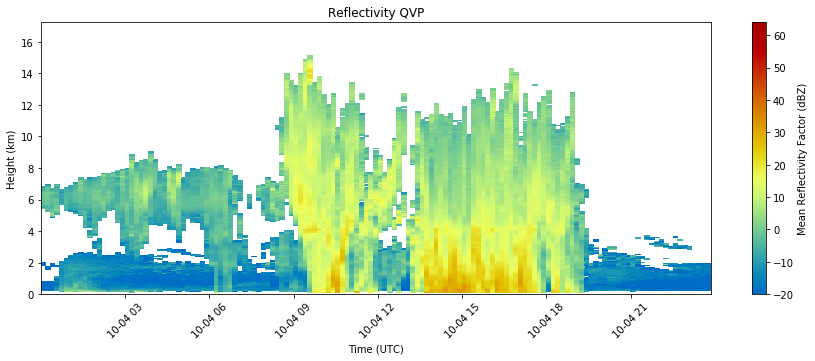

In [217]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_ref.transpose(), 
                     cmap=cmap, vmin=-20, vmax=64)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Reflectivity Factor (dBZ)')
plt.savefig('ref_with_gate_id_zdr>1gatefilter.png', dpi=300)
plt.show()

In [218]:
radar = pyart.io.read('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.160022.nc')
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_below('cross_correlation_ratio', 0.9)
#gatefilter.exclude_above('differential_reflectivity', 4)
gatefilter.exclude_equal('gate_id', 0)
gatefilter.exclude_equal('gate_id', 3)
gatefilter.exclude_equal('gate_id', 5)

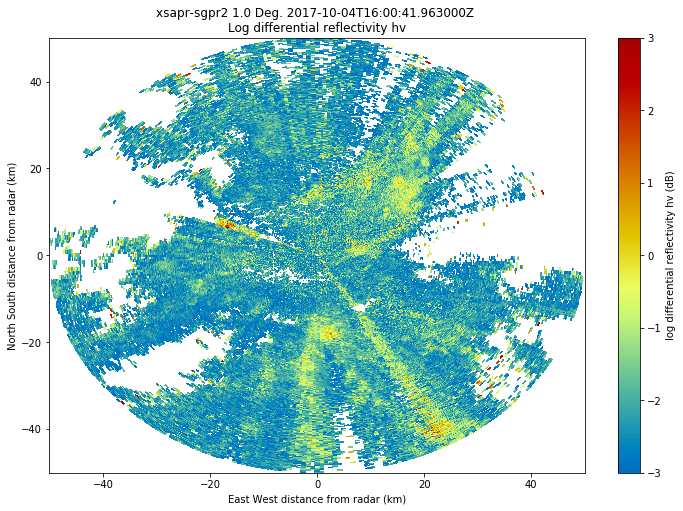

In [219]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(12,8))
display.plot_ppi('differential_reflectivity', sweep=1,# resolution='l', 
                vmin=-3, vmax=3, mask_outside=True,  
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                gatefilter=gatefilter)
#display.basemap.drawcounties()

plt.show()
plt.close()


In [225]:
radar.fixed_angle

{'long_name': 'Target angle for sweep',
 'units': 'degrees',
 'standard_name': 'target_fixed_angle',
 'data': masked_array(data=[ 0.49987793,  0.99975586,  1.4996338 ,  2.4993896 ,
                     3.4991455 ,  4.4989014 ,  5.498657  ,  6.498413  ,
                     7.498169  ,  8.497925  ,  9.497681  , 10.497437  ,
                    11.502686  , 12.502441  , 14.002075  , 15.001831  ,
                    17.001343  , 20.00061   , 24.99939   , 29.998169  ,
                    40.00122   , 49.99878   , 54.99756   , 60.00183   ],
              mask=False,
        fill_value=1e+20,
             dtype=float32)}